# Real-Time Optimization
## Modifier Adaptation with Bayesian Optimization using EIC acquisition
### Semi-batch reactor evaluation

In [3]:
# Loading the necessary packages
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from sklearn.utils import Bunch

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "dotted"

logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.basicConfig(level=logging.ERROR)

from rto.models.semi_batch import SemiBatchReactor
from rto.optimization.optimizer import ModifierAdaptationOptimizer, ModelBasedOptimizer
from rto.optimization.bayesian import ModelBasedBayesianOptimizer
from rto.rto import RTOBayesian, RTO
from rto.adaptation.ma_gaussian_processes import MAGaussianProcesses
from rto.utils import generate_samples_uniform
from rto.experiment.analysis import ExperimentAnalyzer

DATABASE = "/mnt/d/rto_data/thesis-analysis-05.db"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analysis

The real process will be called the "plant", while the uncertain one is the "model". First, we create and instance for each one:

In [4]:
# Our complete model will be called the "plant"
plant = SemiBatchReactor()
# And the uncertain is the "model"
model = SemiBatchReactor(k=[0.053, 0.128, 0.0, 0.0, 5])
# define the constraints
g0 = 0.025
g1 = 0.15
g = np.array([g0, g1])
ubx = [30, 0.002, 250]
lbx = [0, 0, 200]

In [12]:
optimizer = ModelBasedOptimizer(ub=ubx, lb=lbx, g=g, solver={'name': 'de', 'params': {'strategy': 'best1bin', 'tol': 1e-6 }}, backoff=0.0)
# f_plant, u_plant ,_ = optimizer.run(plant, [])
# f_model, u_model ,_ = optimizer.run(model, [])

f_plant = -0.5085930760109818
u_plant = [18.4427644, 0.00110823777, 227.792418]

print(f'Plant: u*={u_plant}, f*={f_plant}')
# print(f'Model: u*={u_model}, f*={f_model}')

Plant: u*=[18.4427644, 0.00110823777, 227.792418], f*=-0.5085930760109818


In [13]:
# load the results
analyzer = ExperimentAnalyzer(DATABASE)
results_ma_de = analyzer.load('MA-GP-DE')
results_ma_sqp = analyzer.load('MA-GP-SQP')

results_processed_ma_de = analyzer.pre_process(results_ma_de, f_plant, u_plant)
results_processed_ma_sqp = analyzer.pre_process(results_ma_sqp, f_plant, u_plant)

results_ma_all = pd.concat([results_processed_ma_de, results_processed_ma_sqp], ignore_index=True)

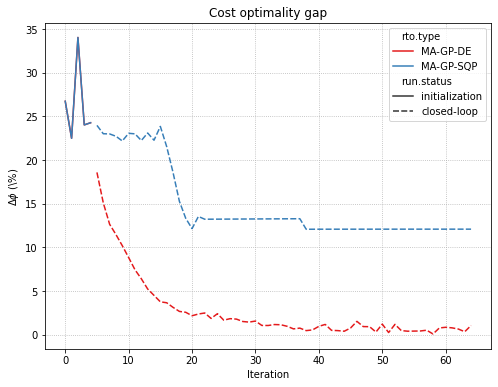

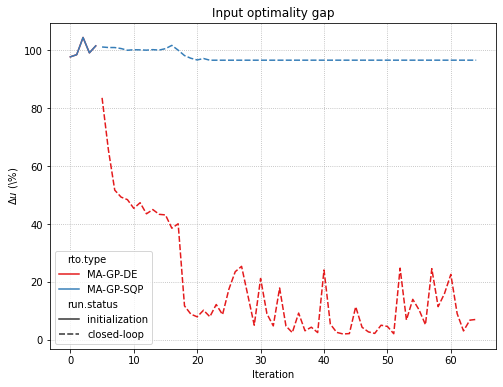

In [14]:
_ = analyzer.plot_by_iteration(results_ma_all, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_ma_all, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')

### Effect of Noise

The results above are for the scenario where we have no noise in the plant measuremets. Since this is not the reality, an interesting test is to check how it can impact the RTO performance. For that, we consider a 0.01 additive gaussian noise, but using the same parameters as the previous system.

In [15]:
# load the results
results_ma_de_noise = analyzer.load('MA-GP-DE+noise')
results_ma_sqp_noise = analyzer.load('MA-GP-SQP+noise')

results_processed_ma_de_noise = analyzer.pre_process(results_ma_de_noise, f_plant, u_plant)
results_processed_ma_sqp_noise = analyzer.pre_process(results_ma_sqp_noise, f_plant, u_plant)

results_ma_noise_all = pd.concat([results_processed_ma_de_noise, results_processed_ma_sqp_noise], ignore_index=True)

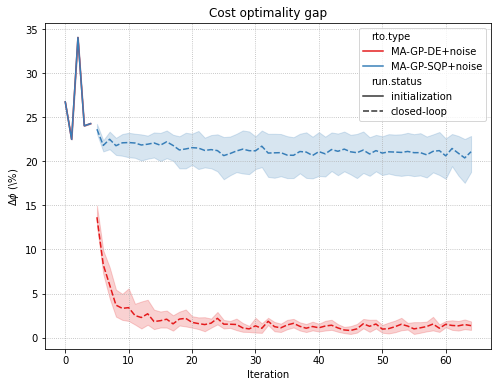

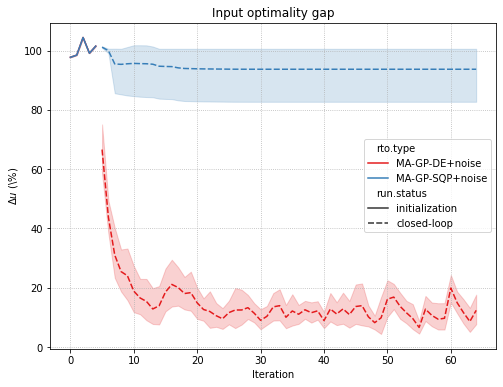

In [16]:
_ = analyzer.plot_by_iteration(results_ma_noise_all, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_ma_noise_all, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')

### Using different initial data points
We start to see more variation, but results are still equivalent for both cases. What if we initialized the system at different starting points?

In [17]:
# load the results
results_ma_de_noise_ds = analyzer.load('MA-GP-DE+noise-datasets')
results_ma_sqp_noise_ds = analyzer.load('MA-GP-SQP+noise-datasets')

results_processed_ma_de_noise_df = analyzer.pre_process(results_ma_de_noise_ds, f_plant, u_plant)
results_processed_ma_sqp_noise_df = analyzer.pre_process(results_ma_sqp_noise_ds, f_plant, u_plant)

results_ma_noise_datasets_all = pd.concat([results_processed_ma_de_noise_df, results_processed_ma_sqp_noise_df], ignore_index=True)

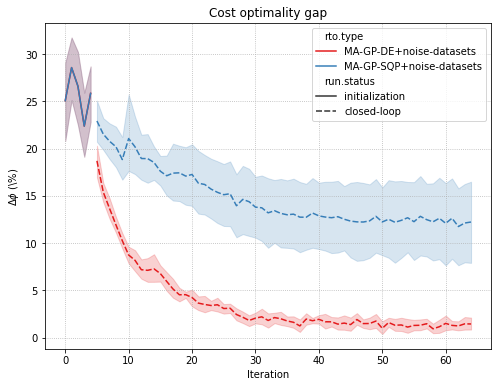

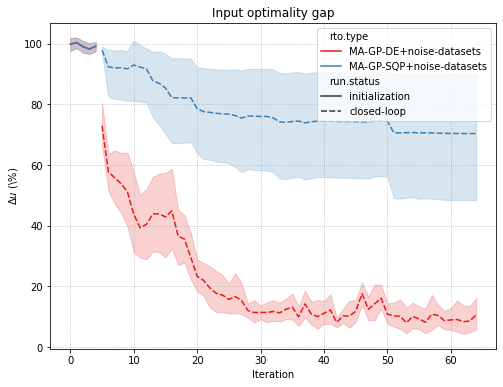

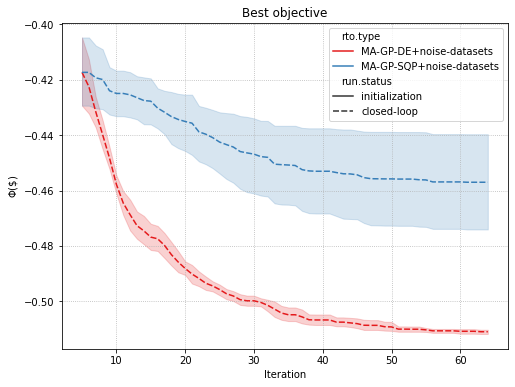

In [18]:
_ = analyzer.plot_by_iteration(results_ma_noise_datasets_all, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_ma_noise_datasets_all, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_ma_noise_datasets_all, 'best_plant_objective', '$\Phi (\$)$', 'Best objective',style='run.status', hue='rto.type')

As seen in the images above, for the Williams-Otto problem, there is a very small effect on using different points for initialiazing the RTO system. Although there is some variation introduced by the measuremente noise,the system easily converges under both optimization algorithms. It is important to notice that this may not be entirely true if the problem exhibits more non-convexity, as investigated in [YY].

## EIC acquisition function

There is a clear link between RTO and Bayesian optimization. Both problems try to optimize and unknown and expensive-to-evaluate function by sampling it according to some heuristics. The main difference lies in the fact that the Bayesian framework is purely data-drive, while in RTO we have a model that, although imperfect, captures the main behavior of the unknown function. Notice that this works as some sort of *prior* knowledge, which in the Bayesian frameork could be historical samples of the function to be optimized, for example.

Considering the MA-GP scheme, one can see that the RTO system learns the plant-model mismatch using GPs and the prior knowledge of the model is used to drive plant optimization. In the Bayesian framework, this is achieved with the use of so-called acquisition functions. Therefore, one could ask the following question: what if we included the acquisition function in RTO procedure? Could this improve the system's performance? 

This was already done by [XX], which applied an EI acquisition to the objective, but used derivative-free and trust-region concepts to handle constrained problems. The idea behind this is to reduce or increase the trust-region size based on thje discrepancy between model estimations and plant measurements. But, one can clearly see that embedding a fully constrained Bayesian framework could be easily achieved. We can change the model-based optimization problem to use the EIC acquisition function, since we have GPs already trained on the constraints mismatch. This turns our constrained problem into a unconstrained one, using a barrier-like objective function.

First, let's run the optimization problem with the EIC acquisition function, using the same default parameters for GP learning. We also run MA-GP as a baseline to compare the results. The last sampled initial operating point is used to start the system. For now, only the noiseless case is considered, to avoid unexpected effects.

### Optimizer Choice

In [21]:
# load the results
analyzer = ExperimentAnalyzer(DATABASE)
# results_bay_nm = analyzer.load('MA-GP-Bayesian-NM')
results_bay_de = analyzer.load('MA-GP-Bayesian-DE')
results_bay_sqp = analyzer.load('MA-GP-Bayesian-SQP')

results_processed_bay_de = analyzer.pre_process(results_bay_de, f_plant, u_plant)
results_processed_bay_sqp = analyzer.pre_process(results_bay_sqp, f_plant, u_plant)
# results_processed_bay_nm = analyzer.pre_process(results_bay_nm, f_plant, u_plant)

results_bayes_all = pd.concat([results_processed_bay_de, results_processed_bay_sqp], ignore_index=True)
# results_bayes_all = pd.concat([results_processed_bay_de, results_processed_bay_sqp, results_processed_bay_nm], ignore_index=True)

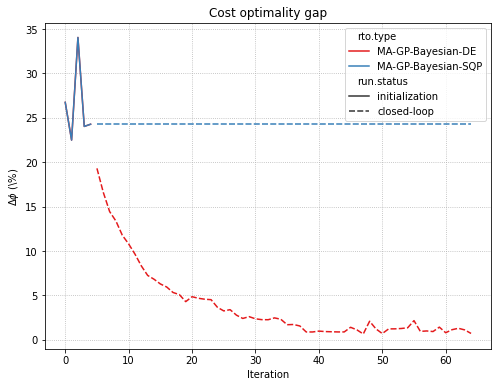

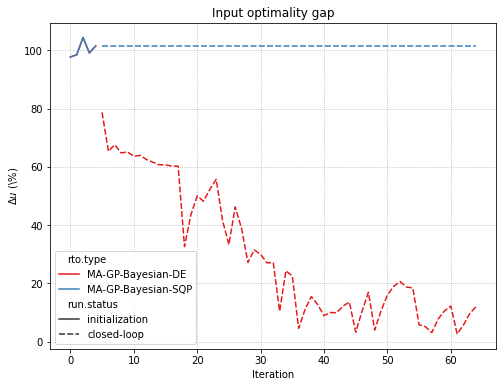

In [22]:
_ = analyzer.plot_by_iteration(results_bayes_all, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap', style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_bayes_all, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')

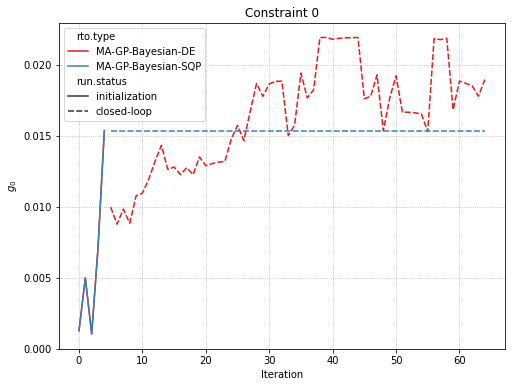

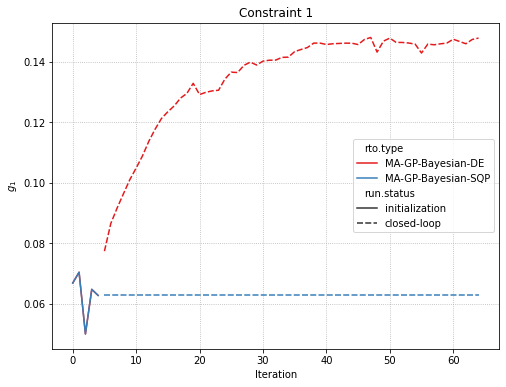

In [23]:
_ = analyzer.plot_by_iteration(results_bayes_all, 'g_0', '$g_0$', 'Constraint 0',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_bayes_all, 'g_1', '$g_1$', 'Constraint 1',style='run.status', hue='rto.type')

### Comparison with MA-GP

As seen before, SQP is unable to even find properly optimizer the EIC function. Therefore, we continue the remainder of this tutorial considering the DE algorithm as the default optimizer. Now, we comparte the results classic MA-GP scheme and with EIC acquisition function, considering the same experimental conditions.

The results for the cost and input optimality gap are displayed below. Notice that using the proposed Bayesian framework, we achieve similar results as the MA-GP baseline. However, the Bayesian approach presents more variability during the optimization steps, we could be related to the way we penalize the constraints violations. As seen previously, the optimal point will lie exactly at the intersection of two constraints, which poses a challenge for the RTO system. 

Another angle is to understand how the EIC acquisition function balances exploration and explotation. Maybe there is some exploitation happening when it shouldn't.

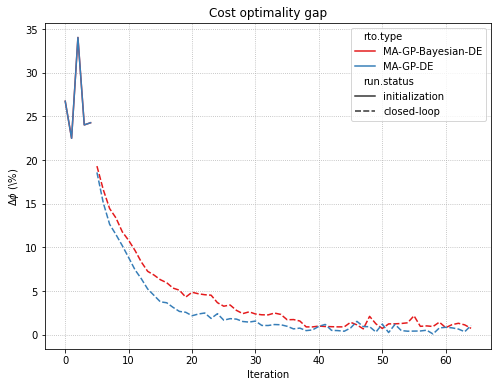

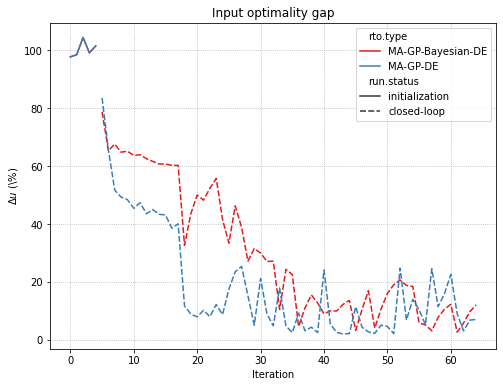

In [24]:
results_bayes_magp = pd.concat([results_processed_bay_de, results_processed_ma_de], ignore_index=True)

_ = analyzer.plot_by_iteration(results_bayes_magp, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap', style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_bayes_magp, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')

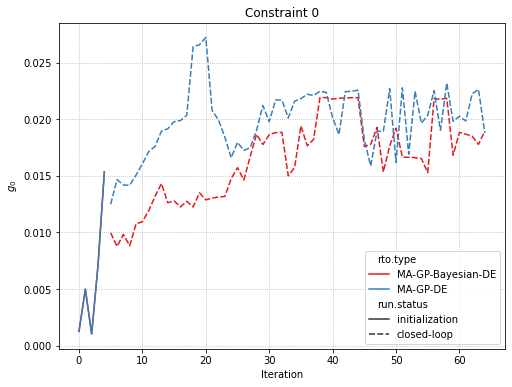

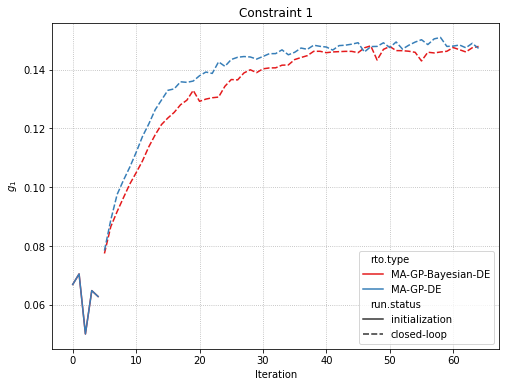

In [25]:
_ = analyzer.plot_by_iteration(results_bayes_magp, 'g_0', '$g_0$', 'Constraint 0',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_bayes_magp, 'g_1', '$g_1$', 'Constraint 1',style='run.status', hue='rto.type')

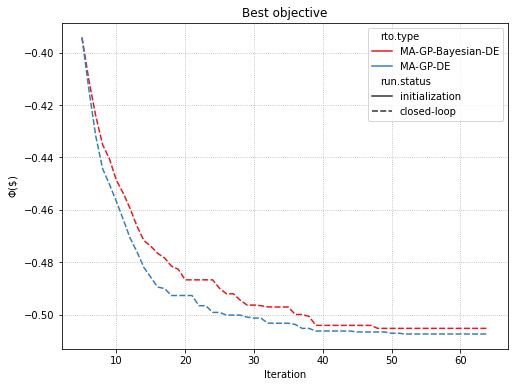

In [26]:
_ = analyzer.plot_by_iteration(results_bayes_magp, 'best_plant_objective', '$\Phi (\$)$', 'Best objective',style='run.status', hue='rto.type')

### Effect of initialization point EIC

As a last experiment, we analyze how the choice of initial operating points could affect the EIC RTO performance. The same initial points from the MA-GP experiment are used, and both approaches are compared.

In [56]:
# #u0, u1, u2 = [], [], []
# #results_bay_processed_datasets_de.groupby('iteration')['u'].mean()
# tm = results_bay_processed_datasets_de.groupby('iteration')['u'].mean().apply(lambda x: float(x[0])) 
# Fs = results_bay_processed_datasets_de.groupby('iteration')['u'].mean().apply(lambda x: float(x[1])) 
# ts = results_bay_processed_datasets_de.groupby('iteration')['u'].mean().apply(lambda x: float(x[2]))


# tm_nm = results_bay_processed_datasets_nm.groupby('iteration')['u'].mean().apply(lambda x: float(x[0])) 
# Fs_nm = results_bay_processed_datasets_nm.groupby('iteration')['u'].mean().apply(lambda x: float(x[1])) 
# ts_nm = results_bay_processed_datasets_nm.groupby('iteration')['u'].mean().apply(lambda x: float(x[2]))

# plt.figure()
# ts.plot()
# ts_nm.plot()

# plt.figure()
# tm.plot()
# tm_nm.plot()

# plt.figure()
# Fs.plot()
# Fs_nm.plot()

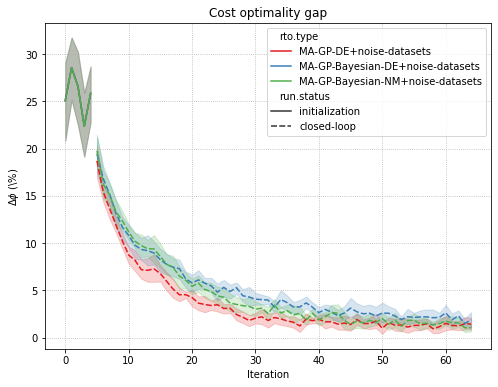

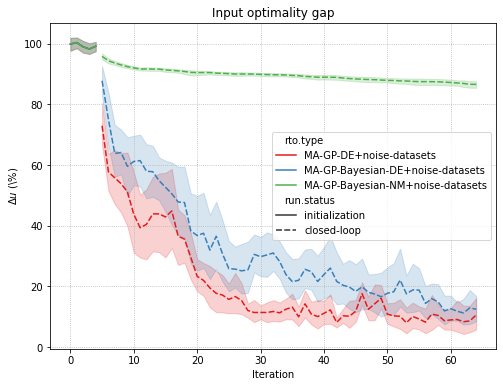

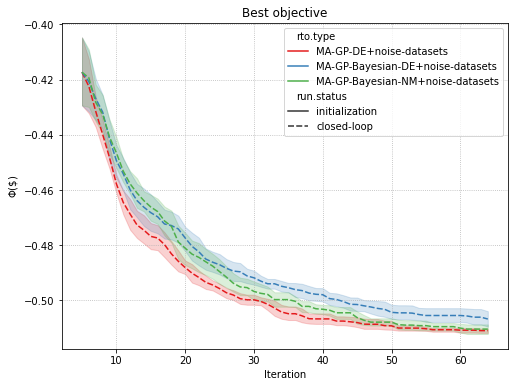

In [30]:
results_bay_datasets_de = analyzer.load('MA-GP-Bayesian-DE+noise-datasets')
results_bay_datasets_nm = analyzer.load('MA-GP-Bayesian-NM+noise-datasets')

results_bay_processed_datasets_de = analyzer.pre_process(results_bay_datasets_de, f_plant, u_plant)
results_bay_processed_datasets_nm = analyzer.pre_process(results_bay_datasets_nm, f_plant, u_plant)

results_bayes_magp_datasets = pd.concat([results_processed_ma_de_noise_df, results_bay_processed_datasets_de, results_bay_processed_datasets_nm], ignore_index=True)

_ = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap', style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'best_plant_objective', '$\Phi (\$)$', 'Best objective',style='run.status', hue='rto.type')

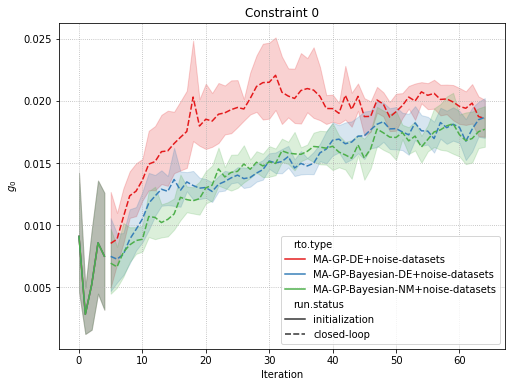

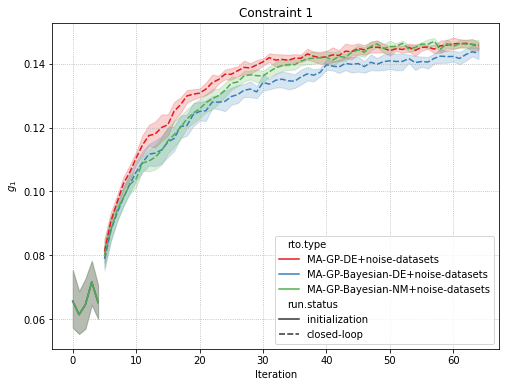

In [31]:
_ = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'g_0', '$g_0$', 'Constraint 0',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'g_1', '$g_1$', 'Constraint 1',style='run.status', hue='rto.type')

From the images above, we notice that both approaches have similar convergence behavior. There is not much difference between them regarding convergence, although one can notice that MA-GP exhibits less variation near the system convergence. This is possibly an effect of the EIC properties discussed proviously.

## Conclusion

This report shows several aspects of the MA-GP RTO problem, as well as the results of a proposed approach using constrained Bayesian optimization with the EIC acquisition function. Using the Williams-Otto reactor, we start showing how the choice of optimiation algorithm and initial points can affect the RTO performance. After that, we start analyzing the novel approach results, using the MA-GP scheme as a baseline. Interesting conclusion could be drawn from this analsys, such that:

* The EIC problem becomes non-convex and thus much harder to be solved by deterministic optimizers.
* Unnecessary exploration of the EIC acquistion leads to the degradation of the RTO performance

Therefore, as a next step, we aim to investigate different instances of the Williams-Otto problem, specially with non-convex feasible regions. This is a way to validate the limits of MA-GP, and also if the EIC exploration can become a valuable property under this situation.